### Задание  

Требуется принять участие в контесте по прогнозированию спроса на новые пары товар/магазин:
https://www.kaggle.com/t/d6212c14bc11462d996f0643bdfef68f 

Описание данных с Kaggle:  
**product_rk** - id of a product, there is only 6 different products in data set  
**store_location_rk** - id of a store  
**period_start_dt** - date (a Monday date of a week)  
**demand** - target variable (double), is missing for the forecasting period (i.e. since 02Dec2019 to 30Dec2019)  
... - other fields in train set are demand driver information

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


train = pd.read_csv('./train.csv')
train.head()

,Unnamed: 0,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG
0,0,40369,309,2016-12-19,29.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,40370,309,2016-12-19,64.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,40372,309,2016-12-19,32.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,40373,309,2016-12-19,10.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,46272,309,2016-12-19,15.0,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
train = train.drop(columns = 'Unnamed: 0')
train['period_start_dw'] = pd.to_datetime(train.period_start_dt).apply(lambda x: x.weekofyear)
train['period_start_dt'] = pd.to_datetime(train.period_start_dt).apply(lambda x: x.timetuple().tm_yday)

with_nan = ['PROMO1_FLAG', 'PROMO2_FLAG', 'NUM_CONSULTANT', 'AUTORIZATION_FLAG']

obj_columns = []
for i in train.columns:
    if train[i].dtype == 'O':
        obj_columns.append(i)
        
for i in train.columns:
    nones = train[i].isna().sum() / train.shape[0]
    print(f'column: {i}\n\tUnique values:{len(train[i].unique())}\n\tNone:{round(nones, 5)}%\n')


column: product_rk
	Unique values:6
	None:0.0%

column: store_location_rk
	Unique values:41
	None:0.0%

column: period_start_dt
	Unique values:159
	None:0.0%

column: demand
	Unique values:1807
	None:0.03395%

column: PROMO1_FLAG
	Unique values:4
	None:0.00523%

column: PROMO2_FLAG
	Unique values:2
	None:0.00523%

column: PRICE_REGULAR
	Unique values:230
	None:0.03189%

column: PRICE_AFTER_DISC
	Unique values:1037
	None:0.03203%

column: NUM_CONSULTANT
	Unique values:2
	None:0.00523%

column: AUTORIZATION_FLAG
	Unique values:3
	None:0.00523%

column: period_start_dw
	Unique values:52
	None:0.0%



In [3]:
train = train.drop(columns=['NUM_CONSULTANT', 'PROMO2_FLAG'])

test = train[train.demand.isna()]
train = train[train.demand.notna()]

train.dropna(inplace=True)
test = test.drop(columns='demand')

print(f'Nones in DataFrame \n{test.isna().sum()}')

Nones in DataFrame 
product_rk             0
store_location_rk      0
period_start_dt        0
PROMO1_FLAG            0
PRICE_REGULAR        120
PRICE_AFTER_DISC     120
AUTORIZATION_FLAG      0
period_start_dw        0
dtype: int64


In [4]:
test = test.fillna(-50)


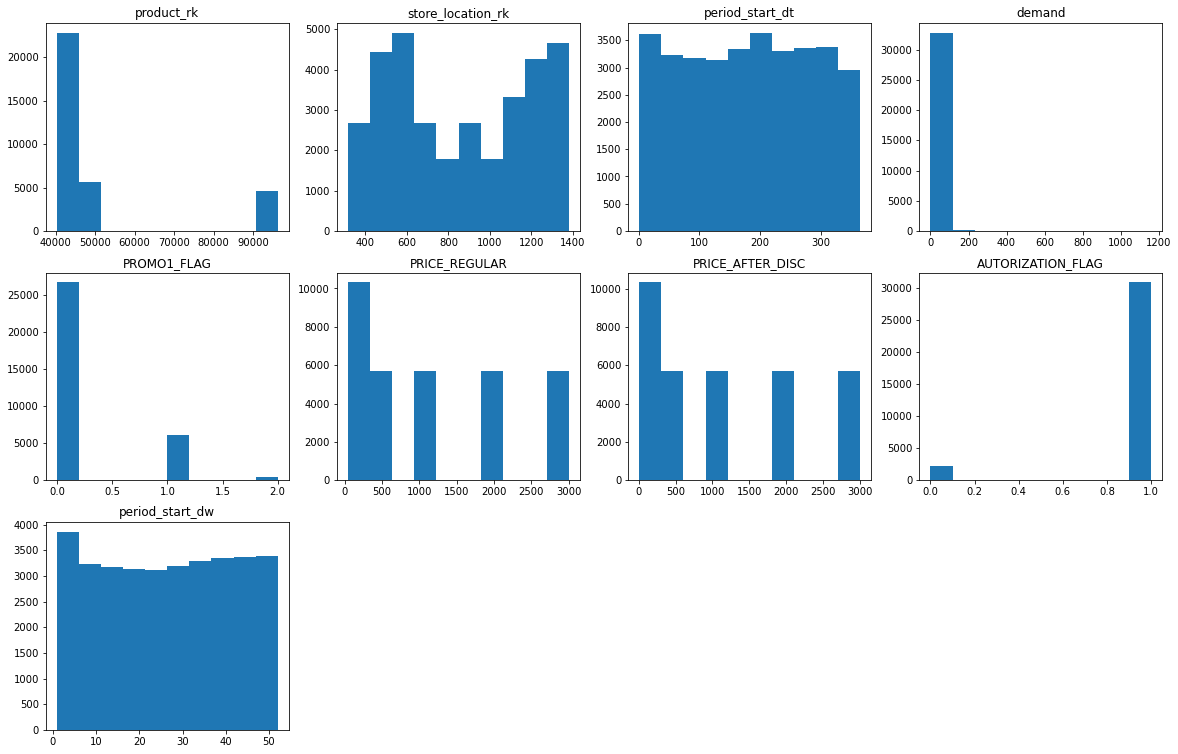

In [5]:
plt.figure(figsize=(20,13))

for i in range(len(train.columns)):
    ax = plt.subplot(3, 4, i + 1)
    ax.hist(train[train.columns[i]])
    ax.set_title(str(train.columns[i]))

plt.show()

In [6]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns='demand'), 
                                                  train.demand, 
                                                  test_size=0.2, 
                                                  random_state=42)

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

categorical = ['product_rk', 'store_location_rk', 'PROMO1_FLAG', 'AUTORIZATION_FLAG']
numeric = ['period_start_dt','PRICE_REGULAR', 'PRICE_AFTER_DISC' ]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

regr = BaggingRegressor(n_estimators=8, random_state=0)

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', regr)
])

In [8]:
pipeline.fit(X_train, y_train).score(X_val, y_val)

0.7907368181302722

In [9]:
def acc(x, y):
    return np.mean(x - y)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_val)

print('Acuracy on train: ', acc(pred_train, y_train))
print('Acuracy on validation: ', acc(pred_test, y_val))


Acuracy on train:  -0.13885882621675172
Acuracy on validation:  -0.2021441883393695


In [10]:
pred = pipeline.predict(test)
sample_sub = pd.read_csv('sample_submission.csv')
sample_sub['predicted'] = pred
sample_sub.to_csv('my_submission.csv', index=0)

regr = BaggingRegressor(n_estimators=10, random_state=0)  
0.7895629853556086  
Acuracy on train:  -0.1579121605093367  
Acuracy on validation:  -0.2516853412705602  
  
regr = BaggingRegressor(n_estimators=8, random_state=0)  
0.7907368181302722  
Acuracy on train:  -0.13885882621675172  
Acuracy on validation:  -0.2021441883393695  
  
